In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

SCOPETYPE = 'OPENADC'
SS_VER='SS_VER_1_1'

In [18]:
scope.dis()
target.dis()

In [19]:
import chipwhisperer as cw

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()



In [20]:
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

INFO: Found ChipWhisperer😍


In [36]:
scope.default_setup()
scope.gain.db = 50
scope.adc.samples = 10000
scope.clock.clkgen_freq = 4e6
scope.clock.adc_src = "clkgen_x4"
scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'

In [37]:
def capture_trace(_ignored=None):
    ktp = cw.ktp.Basic()
    key, text = ktp.next()
    print(key)
    print(text)
    target.set_key(key)
    return cw.capture_trace(scope, target, text).wave

In [38]:
wave = capture_trace()
print("✔️ OK to continue!")

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'15 ab 8c 27 87 7d fc c7 9d d4 fb fb 78 58 70 15')
✔️ OK to continue!


In [39]:
target.set_key(bytes([0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0]))

<IPython.core.display.Javascript object>


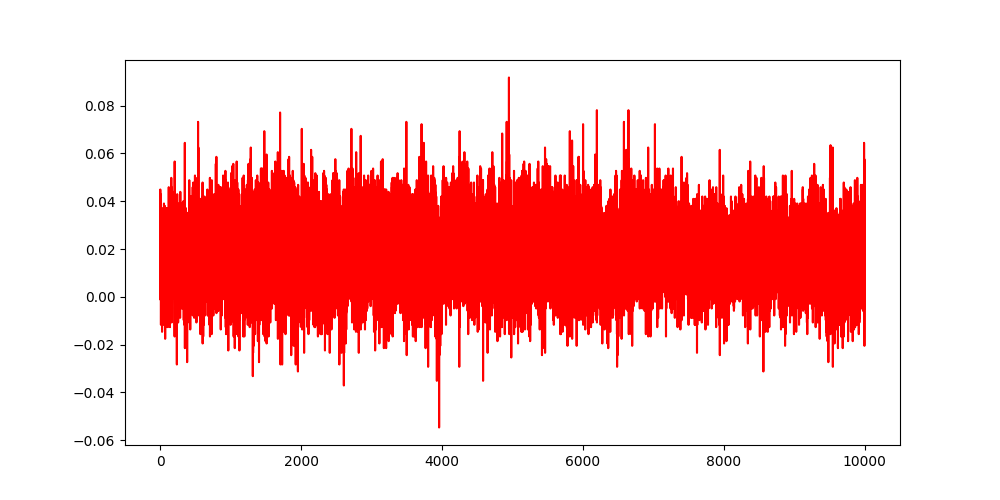

In [40]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
plt.plot(wave, 'r')
plt.show()

In [ ]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
textout_array = []

key, text = ktp.next()

target.set_key(key)

N = 2500
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        
        continue
    
    response = target.simpleserial_read('r', 16)
    textout_array.append(response)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/tmp/ipykernel_2083/1687964465.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/2500 [00:00<?, ?it/s]

In [42]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
# ###################

<IPython.core.display.Javascript object>


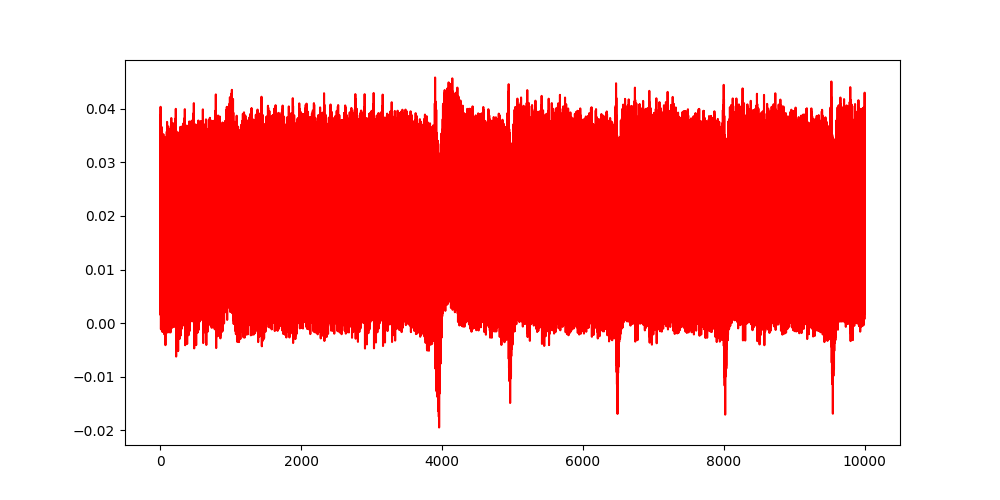

In [43]:
%matplotlib notebook
import matplotlib.pylab as plt

t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)

plt.rcParams["figure.figsize"] = (10,5)
plt.figure()
plt.plot(t_bar, 'r')
plt.show()